In [240]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [241]:
import re

def parse_oscilloscope_data(input_data):
    data = {
        'time_step': None,
        'voltage_step': None,
        'zero_level': None
    }
    
    patterns = {
        'time_step': r'Time step\s*=\s*([\d,]+)\s*([munpf]?)S',
        'voltage_step': r'Voltage step\s*=\s*([\d,]+)\s*([mun]?)V',
        'zero_level': r'Zero level\s*=\s*([\d,]+)'
    }
    
    unit_multipliers = {
        'n': 1e-9,
        'u': 1e-6,
        'm': 1e-3,
        'p': 1e-12,
        'f': 1e-15,
        '': 1
    }
        
    for line in input_data:
        line = line.strip()
        
        if match := re.search(patterns['time_step'], line, re.IGNORECASE):
            value = float(match.group(1).replace(',', '.'))
            unit = match.group(2).lower()
            data['time_step'] = value * unit_multipliers.get(unit, 1)
        
        elif match := re.search(patterns['voltage_step'], line, re.IGNORECASE):
            value = float(match.group(1).replace(',', '.'))
            unit = match.group(2).lower()
            data['voltage_step'] = value * unit_multipliers.get(unit, 1)
        
        elif match := re.search(patterns['zero_level'], line, re.IGNORECASE):
            value = float(match.group(1).replace(',', '.'))
            data['zero_level'] = value
    
    data["zero_level"] *= data['voltage_step']
    
    return data
        

In [242]:
DIRECTORY = "Lab4_data"

FFT_N = 8192

def plot_osc_spec(name, lines, N, FFT_N, CLIP_FFT_N, markers=[], crop_markers_left=0, crop_markers_right=-1, delta_i=15):
    t = []
    x = []
    
    settings = parse_oscilloscope_data(lines[:5])        
    for line in lines:
        if len(line.split("\t")) < 3:
            continue
        try:
            t_i, x_i, _ = list(map(int, line.split("\t")))
        except:
            continue
        
        t.append(t_i * settings["time_step"])
        x.append(x_i)

    t = np.array(t)
    x = np.array(x)
    
    delta_f = 1 / (settings["time_step"] * FFT_N)
    print(settings["time_step"], delta_f)

    plt.figure(figsize=(16, 9))
    print(name)
    plt.xlabel("$t$, мкс")
    plt.ylabel("$U$, В")
    plt.plot(t[:N] * 1e6, x[:N], color="black")
    plt.show()
    
    window = np.array([(1 - np.cos(2 * np.pi * i / (len(x) - 1))) for i in range(len(x))])
    
    X = np.abs(np.fft.fft(x * window, FFT_N))

    X_db = 20 * np.log10(X)

    if len(markers) > 0:
        plt.figure(figsize=(16, 9))
        print(f"FFT with markers, {name}")
        plt.xlabel("$f$, МГц")
        plt.ylabel("$X$, дБ")
        for marker in markers:
            i = int(marker / delta_f * 1e6)
            
            print(crop_markers_left, crop_markers_right)
            
            # print(delta_f, marker, i)
            print(f"marker: {marker}, value: {np.min(X_db[i - delta_i : i + delta_i])} - {np.max(X_db[i - delta_i : i + delta_i])} дБ")
            plt.axvline(x=marker, color='red', linestyle='--', linewidth=2)
            plt.axvline(x=(i - delta_i) * delta_f / 1e6, color='lightgray', linestyle='--', linewidth=1)
            plt.axvline(x=(i + delta_i) * delta_f / 1e6, color='lightgray', linestyle='--', linewidth=1)
        crop_markers_left = int(crop_markers_left / delta_f * 1e6)
        crop_markers_right = int(crop_markers_right / delta_f * 1e6)
        plt.plot(np.arange(FFT_N)[crop_markers_left:crop_markers_right] * delta_f / 1e6, X_db[crop_markers_left:crop_markers_right
                                                                                                                         ])
        plt.show()
    
    X = np.abs(np.fft.fft(x, FFT_N))

    plt.figure(figsize=(16, 9))
    print(f"FFT, {name}")
    plt.xlabel("$f$, МГц")
    plt.ylabel("$X$, дБ")
    plt.plot(np.arange(FFT_N)[:CLIP_FFT_N] * delta_f / 1e6, X_db[:CLIP_FFT_N], color="black")
    plt.show()

for filename in os.listdir(DIRECTORY):
    if not filename.endswith('.txt'):
        continue
    filepath = os.path.join(DIRECTORY, filename)
    
    t = []
    x = []
    
    with open(filepath, "r") as f:
        lines = f.readlines()
        settings = parse_oscilloscope_data(lines[:5])        
        # plot_osc_spec(lines, 8000, 8192)

1e-08 12207.03125
1


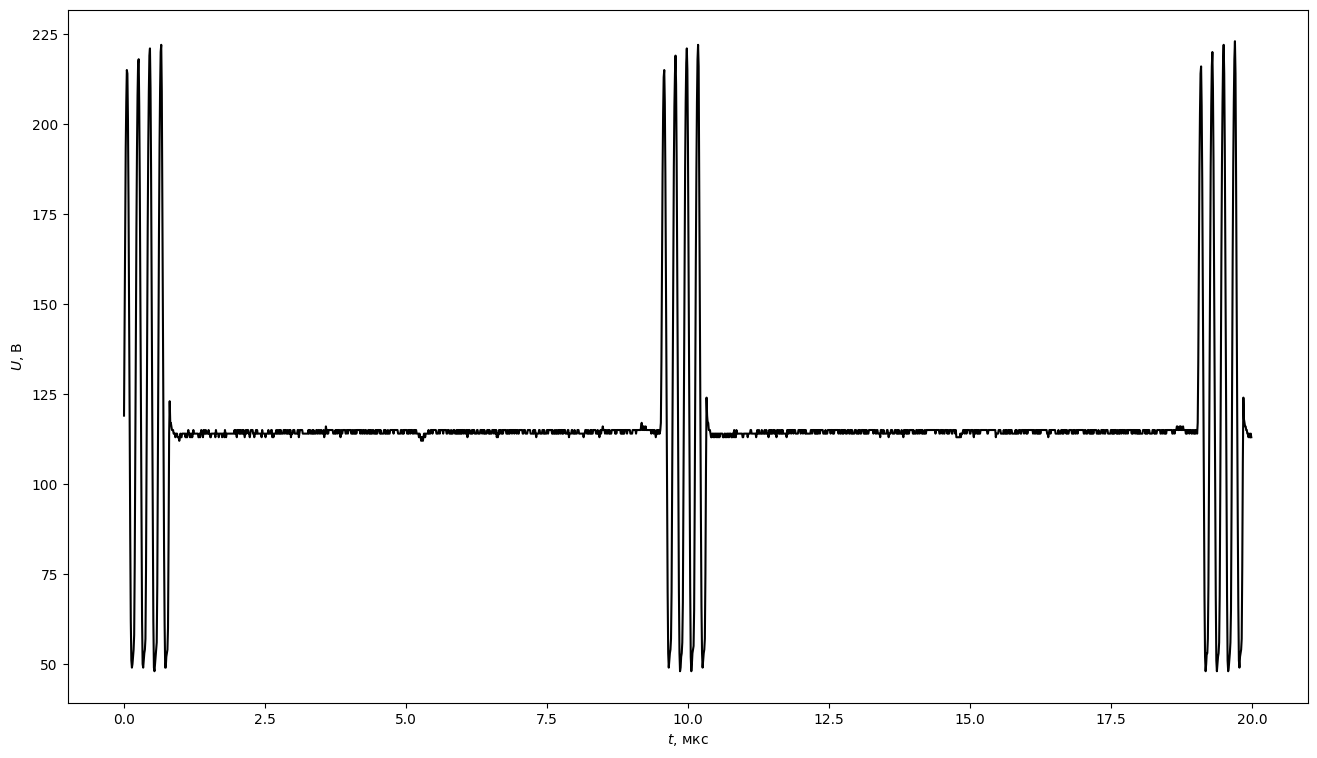

FFT with markers, 1
0 7
marker: 1.9, value: 31.497794304617237 - 74.4926649561717 дБ
0 7
marker: 2.5, value: 28.49570199000756 - 67.82344917517285 дБ
0 7
marker: 3.2, value: 48.369879634721514 - 77.10737564535765 дБ


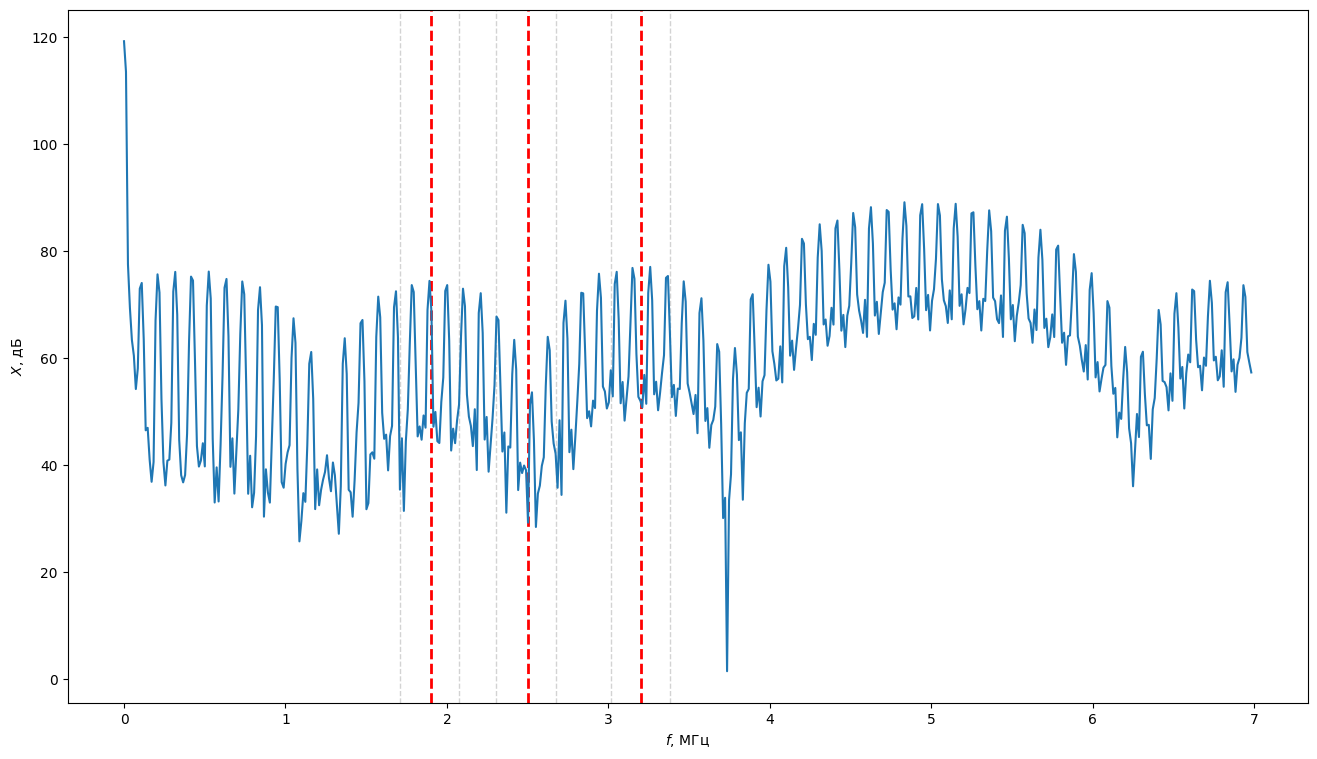

FFT, 1


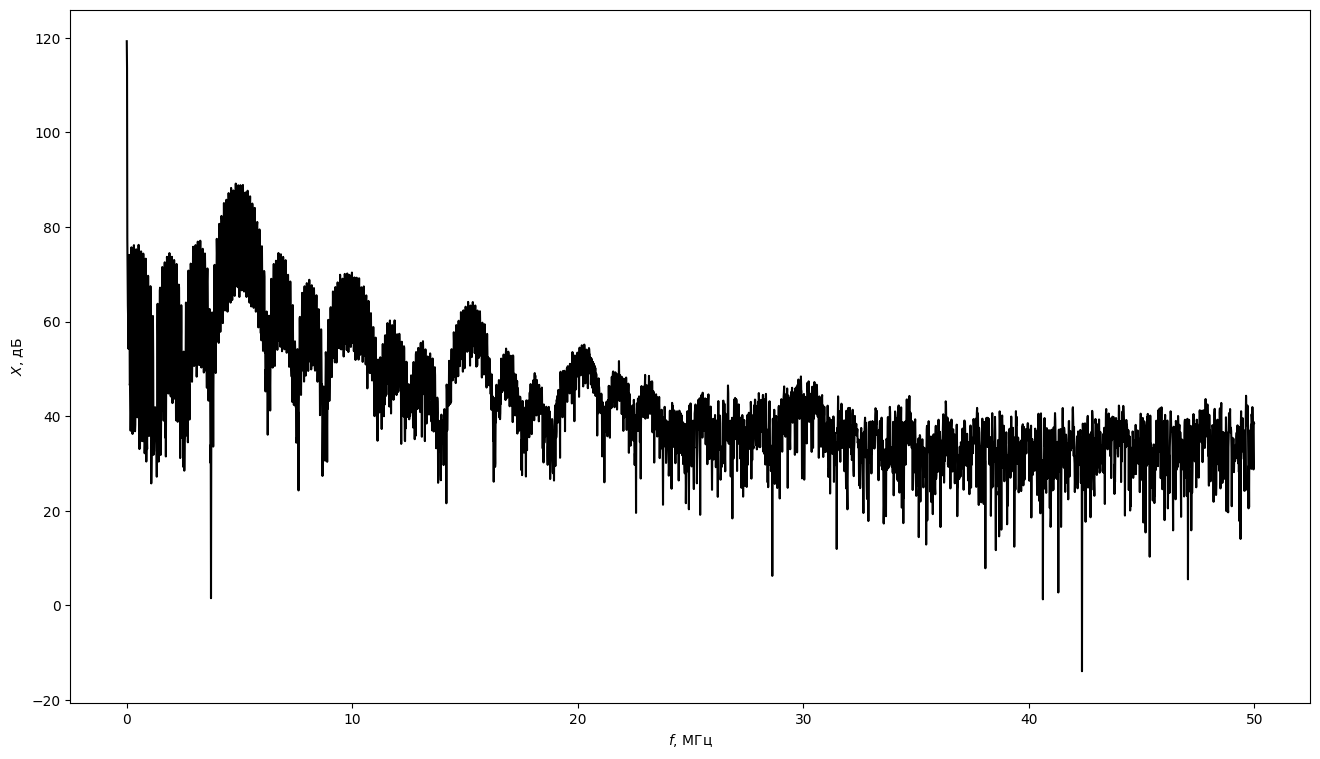

1e-08 12207.03125
2


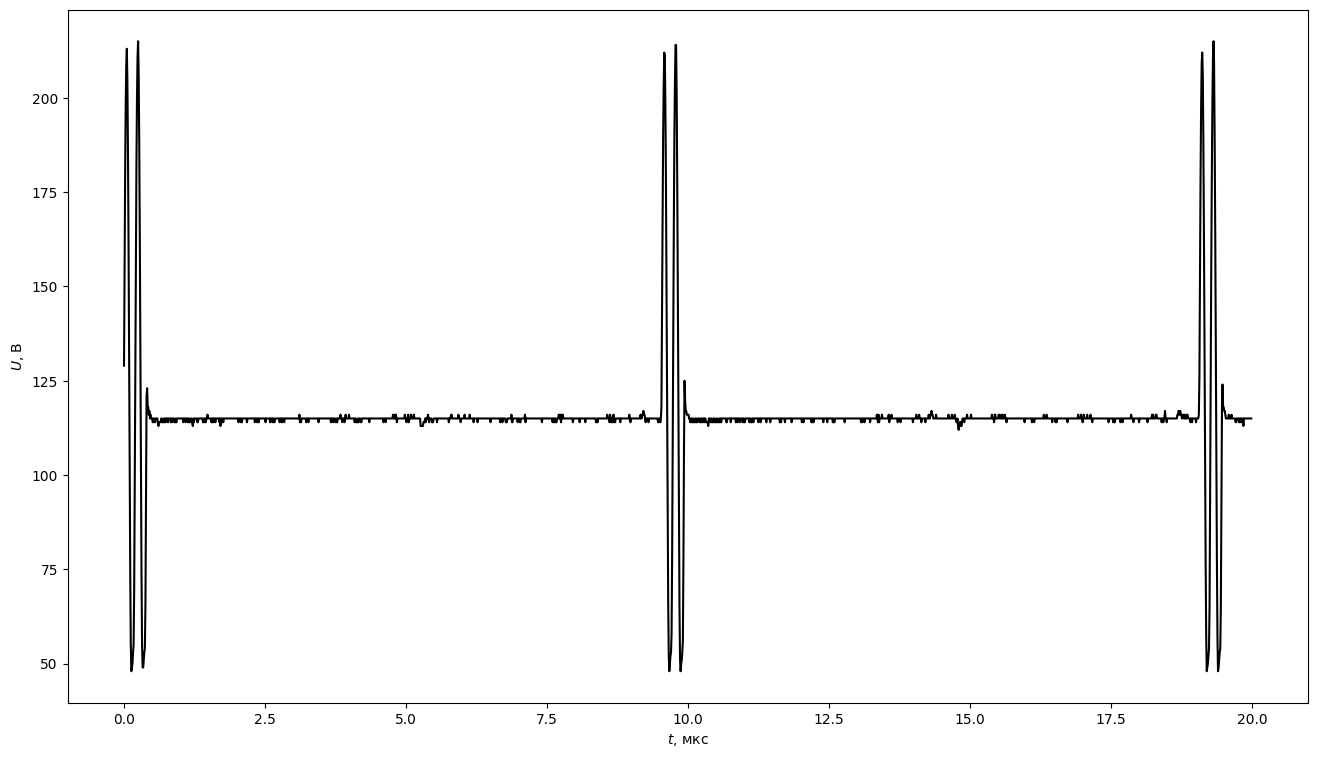

FFT with markers, 2
0 7
marker: 1.9, value: 43.39271373322228 - 71.59065747033195 дБ
0 7
marker: 2.5, value: 30.702992799589865 - 62.414427345582695 дБ
0 7
marker: 3.2, value: 49.3292705914856 - 76.5252070255019 дБ


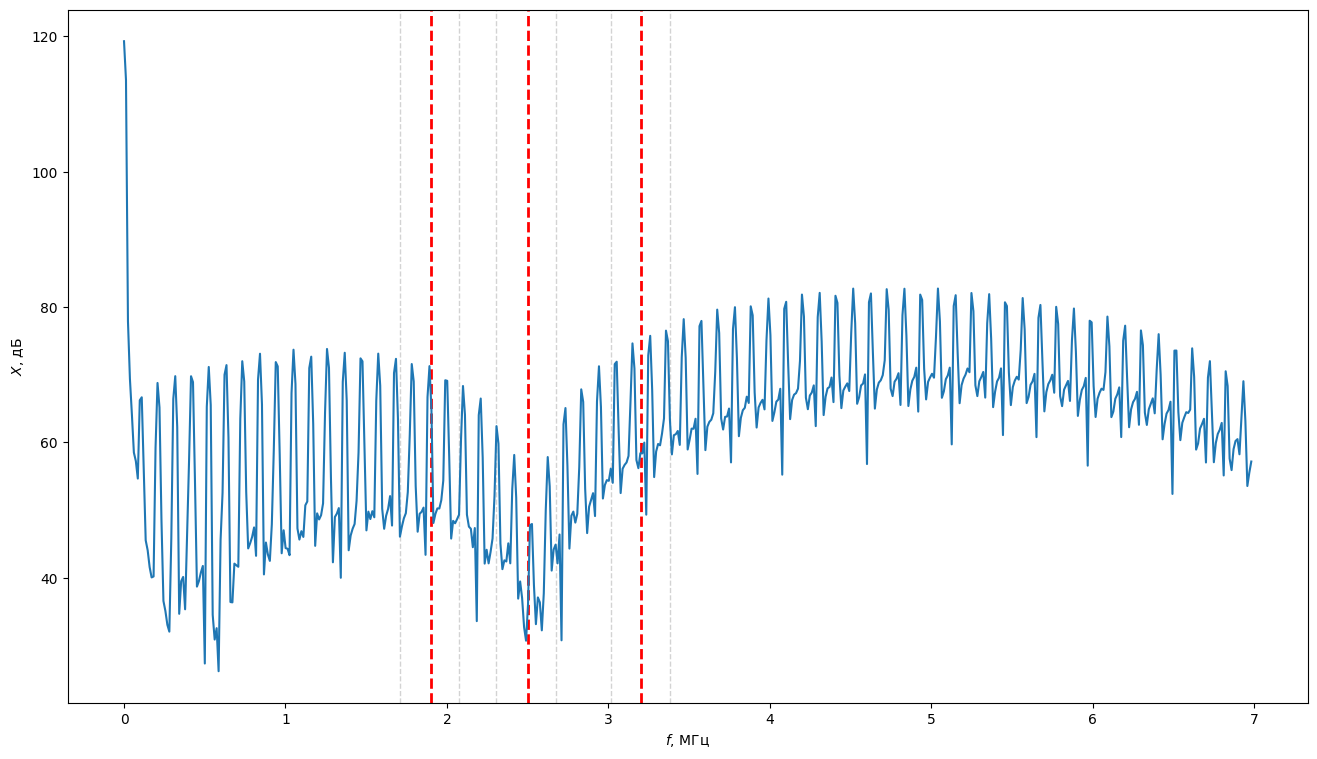

FFT, 2


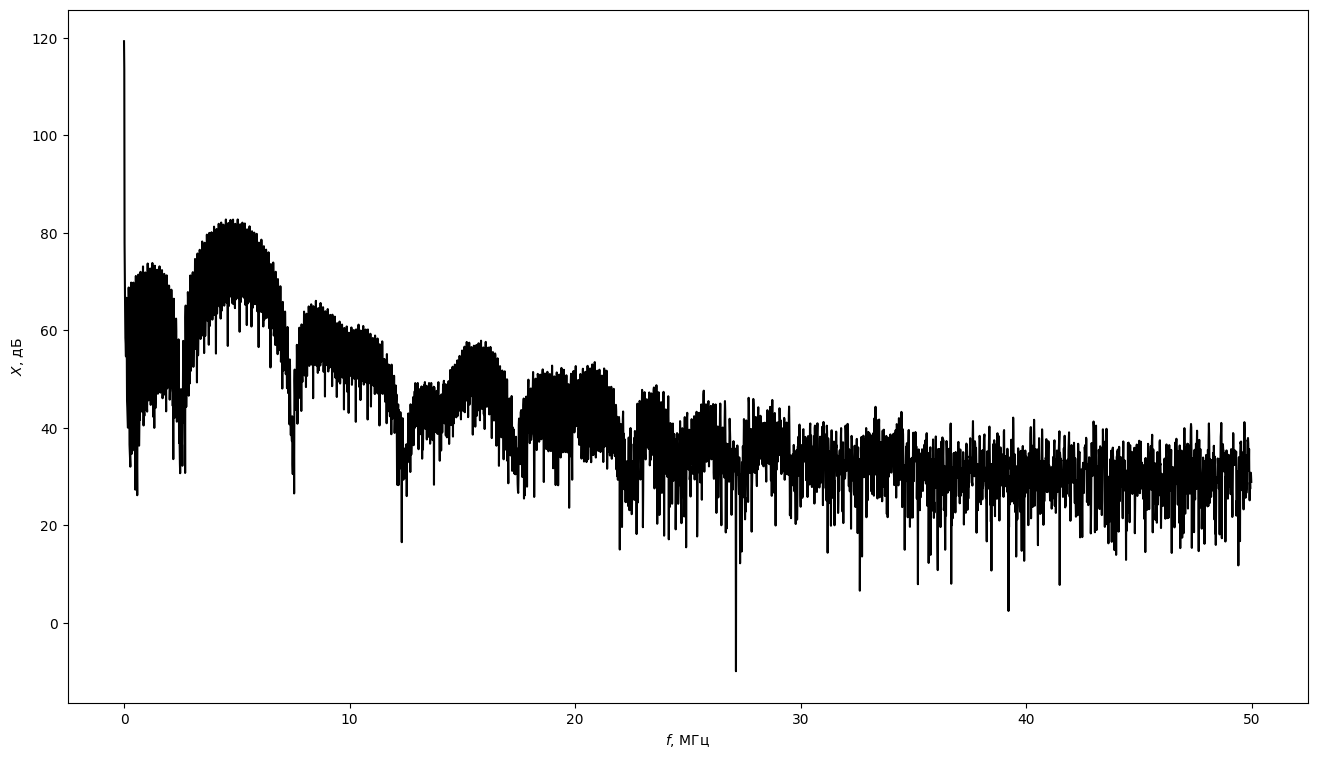

1e-08 12207.03125
3


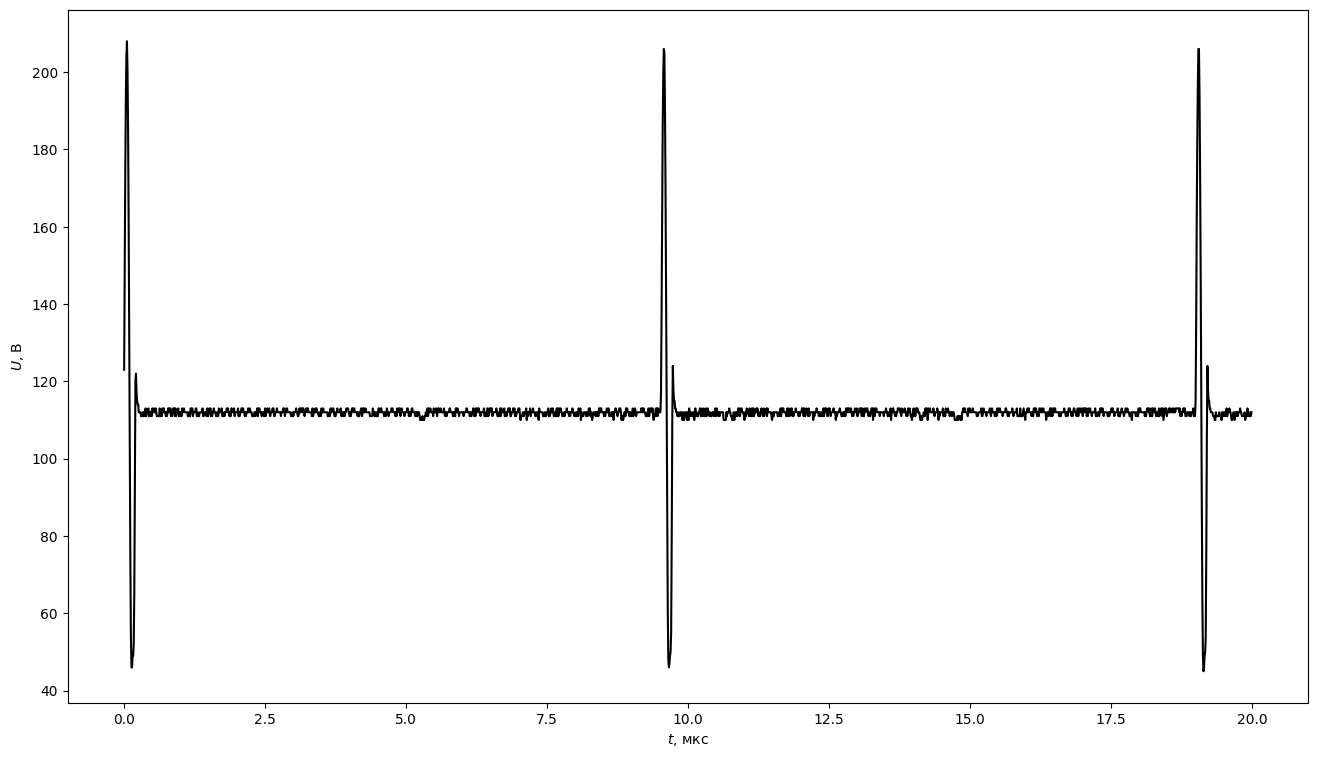

FFT with markers, 3
0 7
marker: 1.9, value: 32.91521030333596 - 73.12751874390197 дБ
0 7
marker: 2.5, value: 41.43828028185232 - 75.20961859784764 дБ
0 7
marker: 3.2, value: 44.442649067311145 - 76.33498054049883 дБ


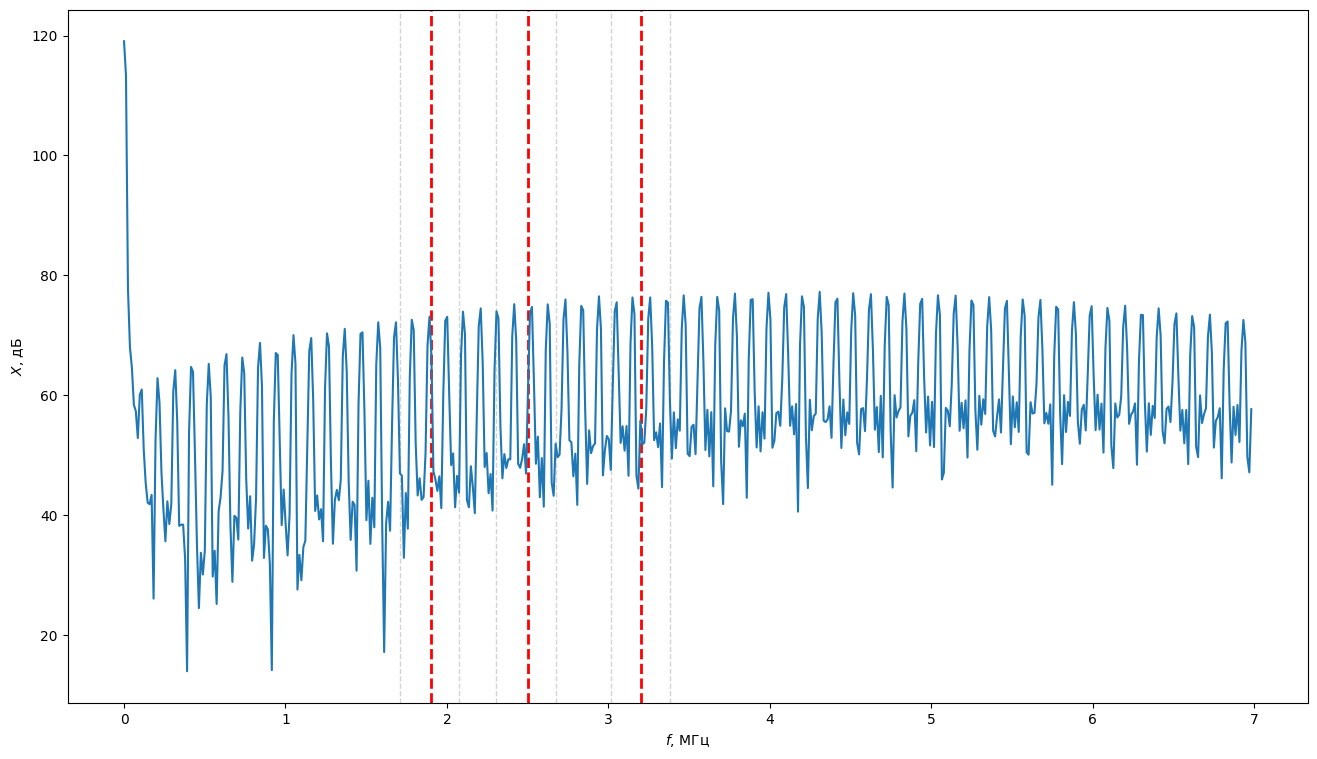

FFT, 3


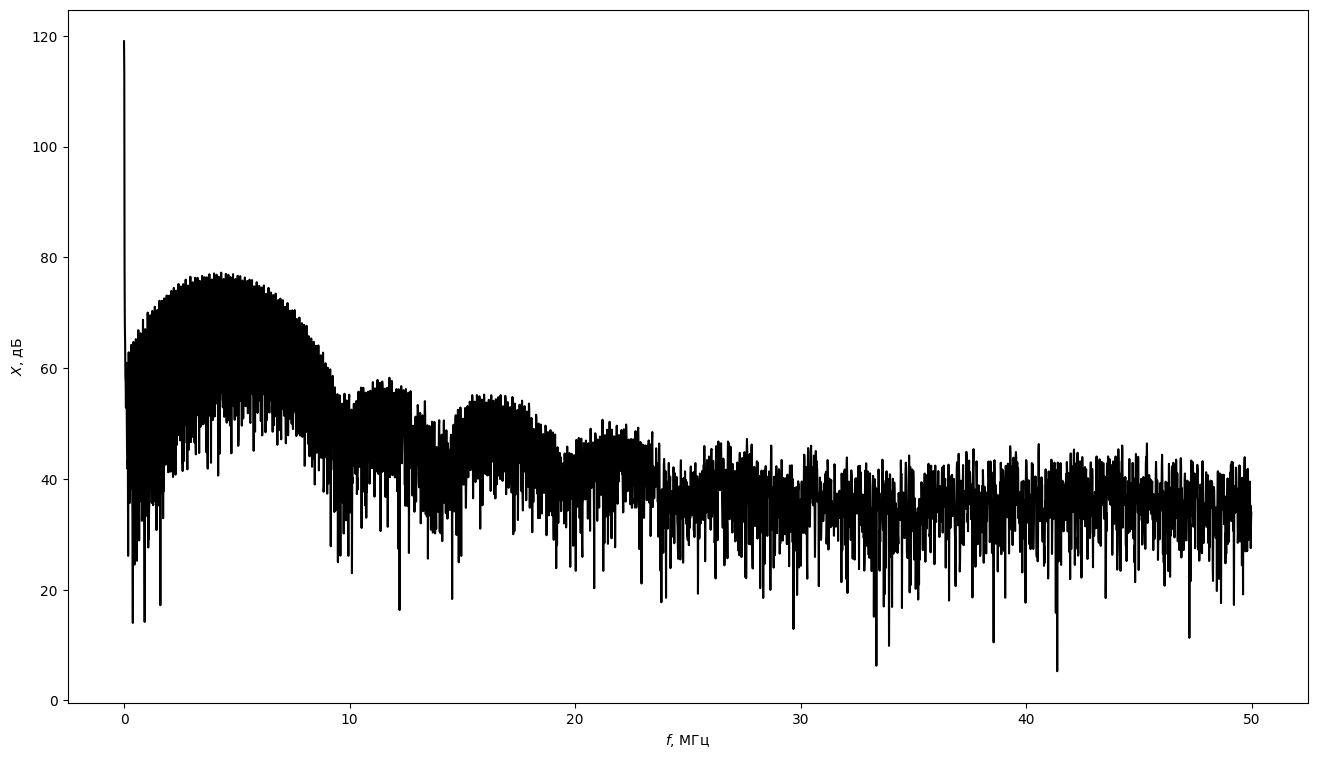

In [243]:
with open("Lab4_data/1_1.txt", "r") as f:
    markers = [1.9, 2.5, 3.2]
    plot_osc_spec("1", f.readlines(), 2000, 8192, 4096, markers, crop_markers_left=0, crop_markers_right=7)

with open("Lab4_data/1_2.txt", "r") as f:
    markers = [1.9, 2.5, 3.2]
    plot_osc_spec("2", f.readlines(), 2000, 8192, 4096, markers, crop_markers_left=0, crop_markers_right=7)

with open("Lab4_data/1_3.txt", "r") as f:
    markers = [1.9, 2.5, 3.2]
    plot_osc_spec("3", f.readlines(), 2000, 8192, 4096, markers, crop_markers_left=0, crop_markers_right=7)

1e-08 12207.03125
2_2


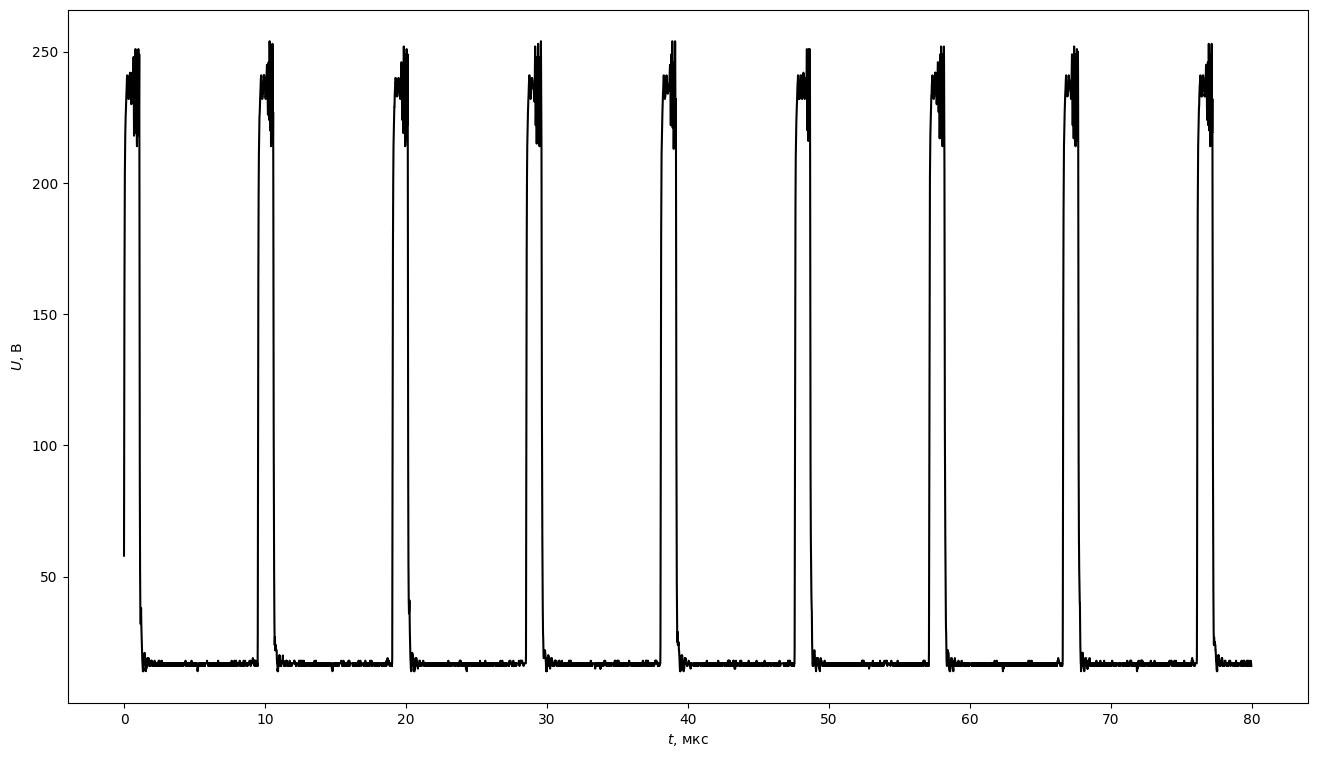

FFT with markers, 2_2
10 20
marker: 11, value: 41.74664874564422 - 56.45728079831351 дБ
10 20
marker: 11.5, value: 53.47416856631776 - 61.203318858263486 дБ
10 20
marker: 12, value: 39.790476535770715 - 58.07098636622825 дБ
10 20
marker: 12.5, value: 43.553434436767084 - 61.34665265913564 дБ
10 20
marker: 13, value: 44.170178256290356 - 59.58102170085559 дБ
10 20
marker: 14, value: 44.39588151693645 - 62.731659915043664 дБ
10 20
marker: 17.5, value: 32.3203438737699 - 53.970515356946656 дБ
10 20
marker: 18, value: 25.178563832380814 - 53.86388044746791 дБ
10 20
marker: 18.5, value: 33.191953237229384 - 54.38500428309227 дБ
10 20
marker: 19, value: 26.33863967187655 - 50.576050605621774 дБ


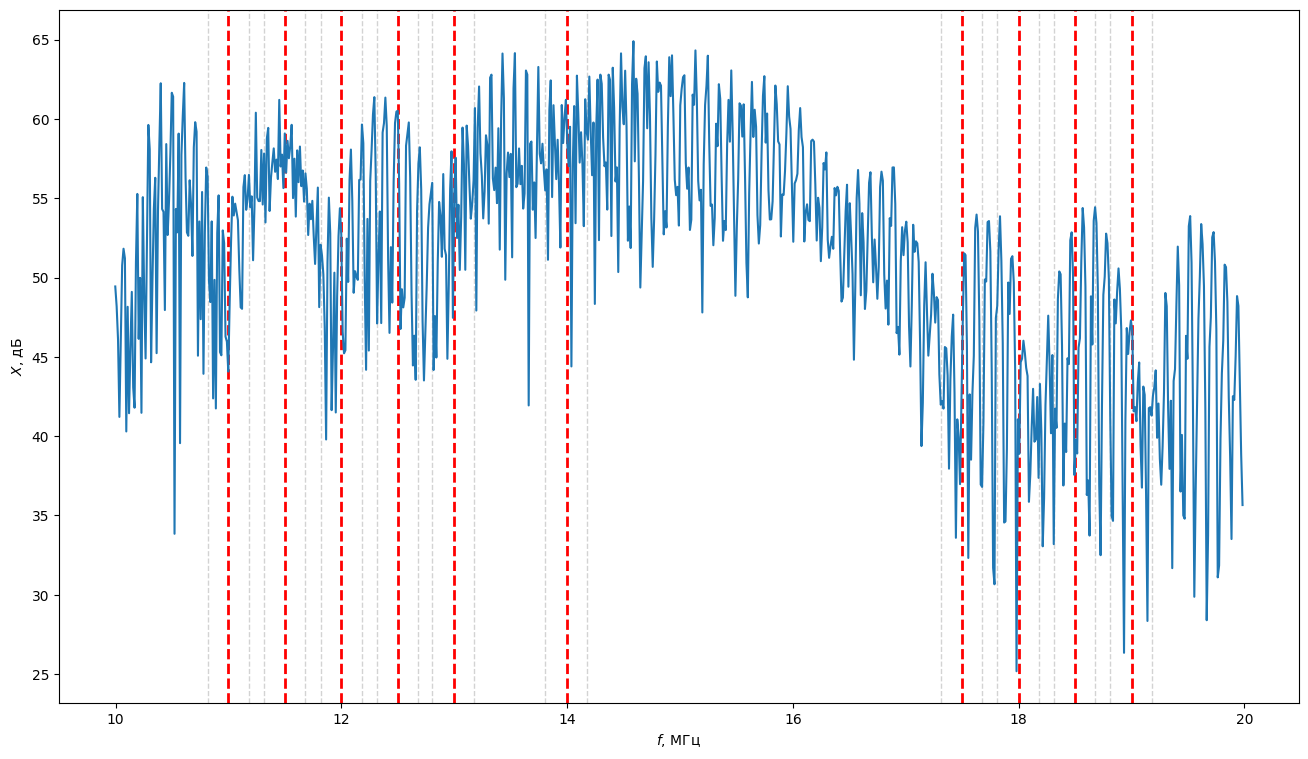

FFT, 2_2


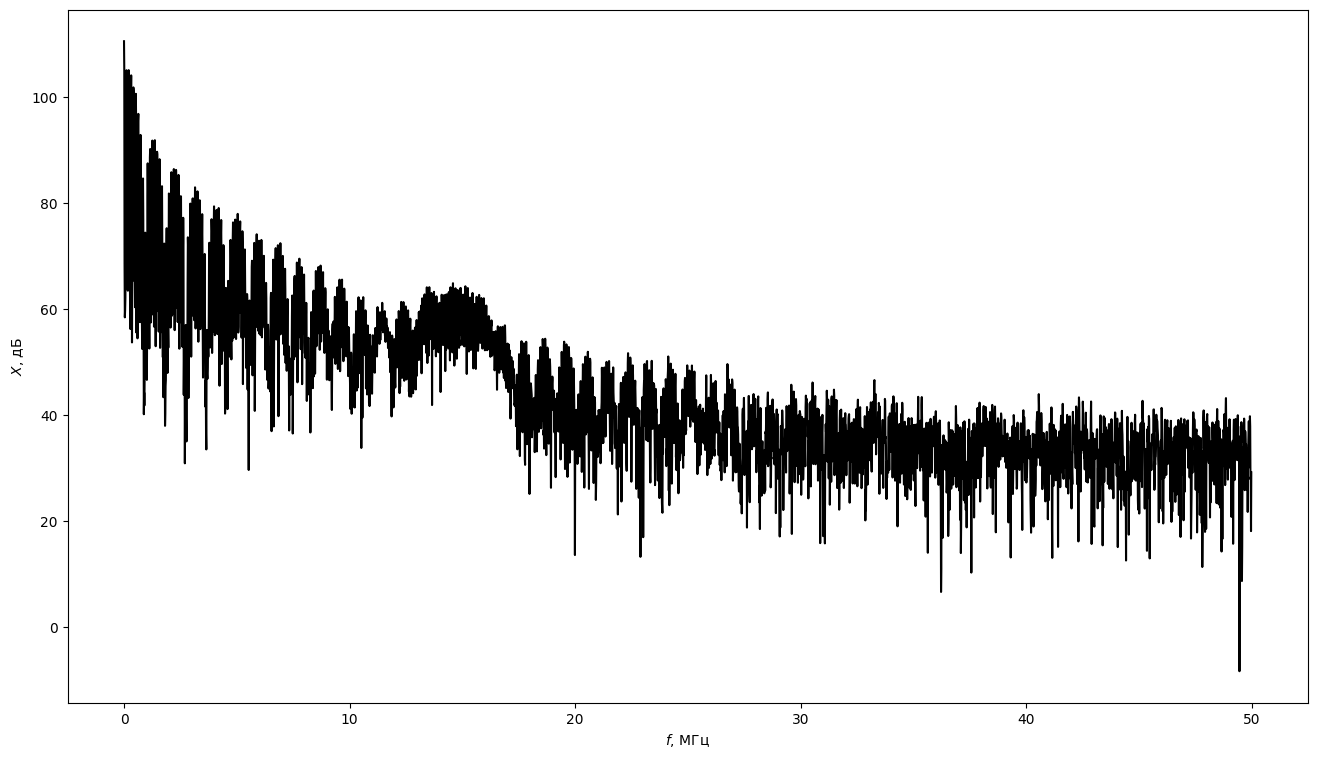

In [244]:
with open("Lab4_data/2_2.txt", "r") as f:
    markers = [11, 11.5, 12, 12.5, 13, 14, 17.5, 18, 18.5, 19]
    plot_osc_spec("2_2", f.readlines(), -1, 8192, 4096, markers, crop_markers_left=10, crop_markers_right=20)